In [1]:
import pandas as pd
import os
def read_excel(excel_path, tab, datetime_fld='Unnamed: 0'):
    df = pd.read_excel(excel_path, tab)
    df.index = pd.to_datetime(df[datetime_fld])
    del df[datetime_fld]
    return df

# InfoWorks ICM Flood Type Storage Comparison

For the 'Stored' option, it uses two stacked cones above ground for storing overflow.

This notebook shows the manual calculation of how it works.

The image below shows how to calculate the area at the flood depth.

Calculating the volume in storage cones:

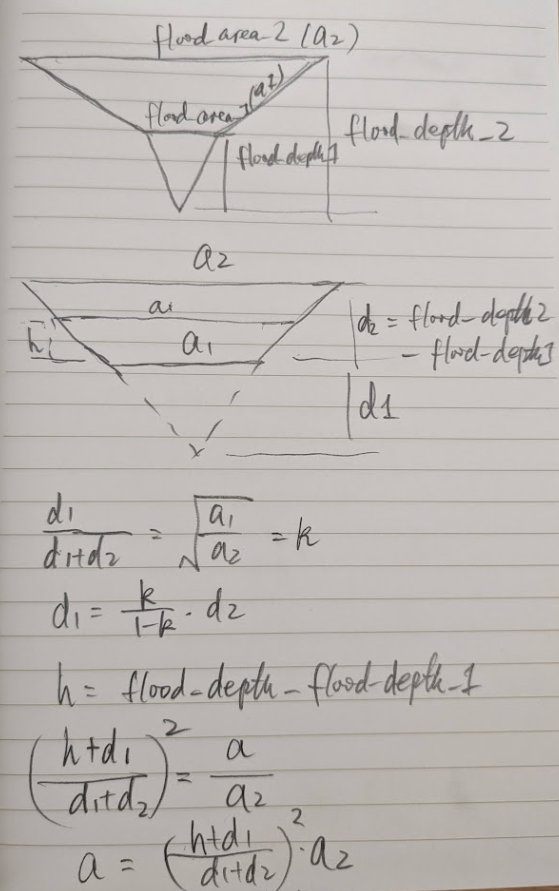

# Sample Model

A sample model can be found in the `model` folder. The 'Stored' node properties is shown below,

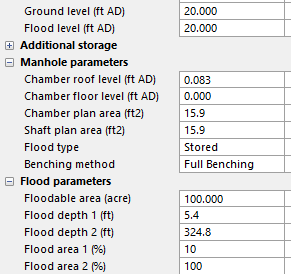

In [16]:
flood_depth = 1.375 #ft
flood_depth_1 = 1 #ft
flood_depth_2 = 324.8 #ft
flood_area_1 = 10 #acre
flood_area_2 = 100 #acre 
shaft_area=15.9 #sf
shaft_area=shaft_area/43560 #acre
vol = flood_vol(flood_depth, flood_depth_1, flood_depth_2, flood_area_1, flood_area_2, shaft_area)
vol_check = 0.1 #mg
print('volume = {}MG vs {}MG'.format(vol, vol_check))

adjusted flood_depth_1 from 1 to 5.430647373063918
volume = 0.09808127222561157MG vs 0.1MG


Below is the manual calculation, the key is from line 14-22 in the cell below, the adjustment to the flood_depth_1, flood_depth_2, an internal check to ensure the cone is not too flat.

In [2]:
def flood_vol(flood_depth, flood_depth_1, flood_depth_2, flood_area_1, flood_area_2, shaft_area=15.9/43560):
    """calculate the flood volume based on ICM flooding cones
    https://help.autodesk.com/view/IWICMS/2024/ENU/?guid=GUID-4625AD3F-710E-4733-99CD-9574B7E6BD3B

    Args:
        flood_depth (float): ft
        flood_depth_1 (float): ft
        flood_depth_2 (float): ft
        flood_area_1 (float): acre
        flood_area_2 (float): acre
    
    return float: the total flood volume
    """
    fd1 = (flood_area_1/shaft_area)**0.5/100*3.281
    if fd1 > flood_depth_1:
        print('adjusted flood_depth_1 from {} to {}'.format(flood_depth_1, fd1))
        flood_depth_1 = fd1
   
    fd2 = (flood_area_2/flood_area_1)**0.5/100*3.281 + flood_depth_1
    if fd2 > flood_depth_2:
        print('adjusted flood_depth_2 from {} to {}'.format(flood_depth_2, fd2))
        flood_depth_2 = fd2
    if flood_depth <= flood_depth_1:

        # inside the bottom cone
        area = (flood_depth/flood_depth_1)**2*flood_area_1 #acre
        vol = 1/3*(area + shaft_area + (area*shaft_area)**0.5)*flood_depth # acre-ft
        vol_mg = vol*43560*7.48052/1e6 #million gallon
        # print(area, vol, vol_mg)
    else:
        # bottom cone
        vol1 = 1/3*(flood_area_1 + shaft_area + (flood_area_1*shaft_area)**0.5)*flood_depth # acre-ft
        vol1_mg = vol1*43560*7.481/1e6 #million gallon
        # top cone
        k = (flood_area_1/flood_area_2)**0.5
        d2 = flood_depth_2 - flood_depth_1
        d1 = d2*k/(1 - k)
        h1 = flood_depth - flood_depth_1
        area = flood_area_2*((h1 + d1)/(d1 + d2))**2
        vol2 = 1/3*(area + flood_area_1 + (area*flood_area_1)**0.5)*flood_depth # acre-ft
        vol2_mg = vol2*43560*7.481/1e6 #million gallon
        vol_mg = vol1_mg + vol2_mg
    
    return vol_mg




The hand calculated results don't match the simulated results.


adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373063918
adjusted flood_depth_1 from 1.0 to 5.430647373

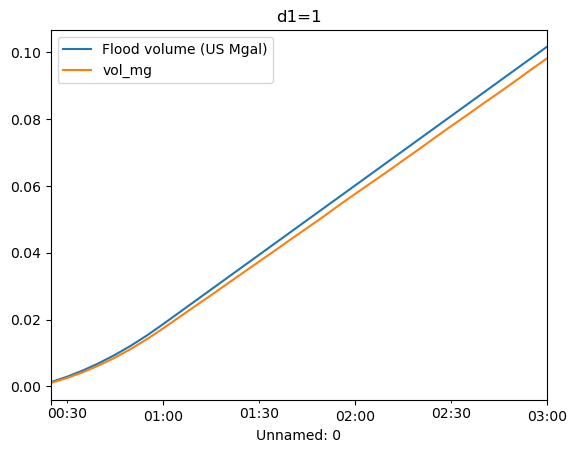

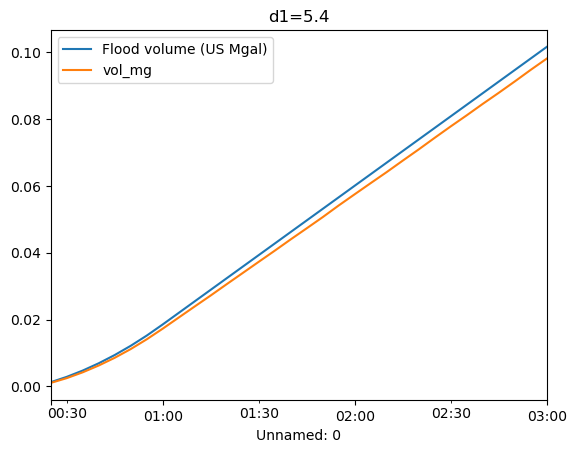

In [22]:
ws = './data'
excel_path = os.path.join(ws, 'sim.xlsx')
for tab in ['d1=1', 'd1=5.4']:#['depth=3.3', 'depth=6', 'depth=30']:
    _, flood_depth_1 = tab.split('=')
    flood_depth_1 = float(flood_depth_1)
    df = read_excel(excel_path, tab)
    df['vol_mg'] = df.apply(lambda x: flood_vol(x['Flood depth (ft)'], flood_depth_1, flood_depth_2, flood_area_1, flood_area_2, shaft_area), axis=1)
    df = df.loc[df['Flood depth (ft)'] > 0,]
    ax = df.loc[df['Flood depth (ft)'] > 0, ['Flood volume (US Mgal)', 'vol_mg']].plot()
    ax.set_title(tab)
    # print('{}: manual calculated/simulated ratio'.format(tab))
    # print((df['vol_mg']/df['Flood volume (US Mgal)']).head(10))
    # (df['vol_mg']/df['Flood volume (US Mgal)']).plot()

<AxesSubplot: xlabel='Flood depth (ft)', ylabel='vol_mg'>

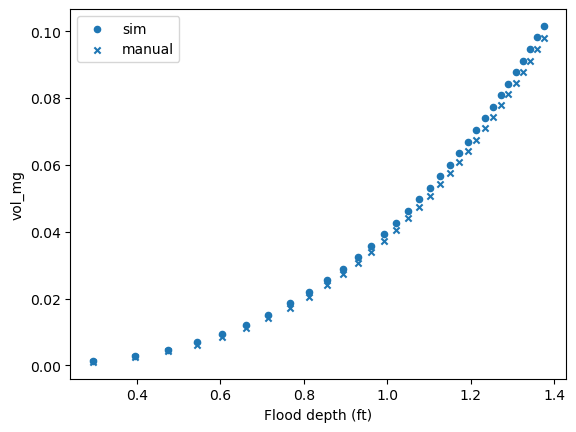

In [20]:
ax = df.plot.scatter(x='Flood depth (ft)', y='Flood volume (US Mgal)', label='sim')
df.plot.scatter(x='Flood depth (ft)', y='vol_mg', label='manual', ax=ax, marker='x')
